# Майнор по Анализу Данных, Группа ИАД-4
## 05/10/2017 Бустинг

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Майнор-по-Анализу-Данных,-Группа-ИАД-4" data-toc-modified-id="Майнор-по-Анализу-Данных,-Группа-ИАД-4-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Майнор по Анализу Данных, Группа ИАД-4</a></div><div class="lev2 toc-item"><a href="#05/10/2017-Бустинг" data-toc-modified-id="05/10/2017-Бустинг-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>05/10/2017 Бустинг</a></div><div class="lev1 toc-item"><a href="#Алгоритм-Ada-boost" data-toc-modified-id="Алгоритм-Ada-boost-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Алгоритм Ada-boost</a></div><div class="lev2 toc-item"><a href="#Повторяем-теорию" data-toc-modified-id="Повторяем-теорию-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Повторяем теорию</a></div><div class="lev2 toc-item"><a href="#Игрушечная-практика" data-toc-modified-id="Игрушечная-практика-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Игрушечная практика</a></div><div class="lev1 toc-item"><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Градиентный бустинг</a></div><div class="lev2 toc-item"><a href="#Повторяем-теорию" data-toc-modified-id="Повторяем-теорию-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Повторяем теорию</a></div><div class="lev2 toc-item"><a href="#Игрушечная-практика" data-toc-modified-id="Игрушечная-практика-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Игрушечная практика</a></div><div class="lev1 toc-item"><a href="#Настоящая-практика" data-toc-modified-id="Настоящая-практика-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Настоящая практика</a></div>

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print u'Так надо'

# Алгоритм Ada-boost

## Повторяем теорию

Boosting, в отличие от bagging'а - это последовательный способ построения композиции базовых моделей.

Мы постоянно работаем с одним и тем же набором данных, **но** на каждом шаге строим новую базовую модель, которая учитывает ошибки предыдущей модели.<br\>По большому счету, бустинг-алгоритмы отличаются лишь тем, как в них заложен учет этих самых ошибок.

Например в методе AdaBoost каждому объекту присваивается вес, который изменяется в зависимости от того, ошиблась ли на нем очередная композиция базовых алгоритмов или нет. Так же веса имеются и у самих базовых моделей, которые штрафуют их за плохие предсказания. Для задачи классификации этот процесс можно проиллюстрировать следующим образом:

<img src='https://s9.postimg.org/lq3lethhr/boosting.png' width='650'>

Введем следующие обозначения:
* $t_k$ - базовый классификатор, полученный на шаге $k$
* $\alpha_k$ - вес базового классификатора, полученного на шаге $k$
* $w_k(i)$ - веса объектов на шаге $k$
* $x_i$ - $i$-й объект, $i = 1, \dots, N$
* $y_i=\{-1, 1\}$ - метки класса для $i$-го объекта 

Конечное предсказание получается из взвешенной комбинации предсказания базовых моделей:
$$ T(x^*) = sign(\sum\limits^{K}_{k=1}\alpha_kt_k(x^*)) $$

Наша цель - минимизировать количество ошибок на всей выборке ..

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] $$

.. которые мы мажорируем экспонентой =)

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] \leq \frac{1}{N}\sum\limits_{i=1}^N e^{(-y_i\sum_k\alpha_kt_k(x_i))} $$

Если мы посчитаем ошибки $E_1, E_2, E_3,...$ на каждом шаге, то это даст нам правило для обновления весов объектов. (Упражнение)<br\>
А если мы посчитаем ошибки производную $E_t$ по $\alpha_t$, то это даст нам правило для обновления весов базовых моделей. (Упражнение)<br\>

Алгоритм обучения **Discrete AdaBoost**:

* Инициализируем веса объектов $w(i)_1 = \frac{1}{N}$ 
* Для $k = 1..K$
    * Обучить классификатор $t_k(x) \in \{-1, 1\}$ используя веса объектов $w(i)_k$
    * Вычислить ошибку взвешенную ошибку $\epsilon = \frac{\sum_i w_{k}(i)[y_i \neq t_k(x_i) ]}{\sum_i w_{k}(i)}$
    * Вычислить вес базовой модели $\alpha_k = \ln\frac{1-\epsilon}{\epsilon}$
    * Пересчитать веса объектов $w_{k+1}(i) = \frac{w_{k}(i) e^{-\alpha_k y_i t_k(x_i)}}{W}$, $i = 1, \dots, N$,где $W = \sum_i w_k(i) e^{-\alpha_k y_i t_k(x_i)}$ - нормировочная константа.
* $T(x) = sign(\sum_k \alpha_k t_k(x))$

Можно вывести аналогичный алгоритм для задачи регрессии.

*Обратите внимание* что базовые модели как правило явлюятся слабыми (weak learners), т.е. их качество должно едва ли превышать бросание монетки. На рисунке выше - это логические правила на одном из признаков, что равносильно дереву решений с глубиной 1.

Раз все понятно, то перейдем к игрушечной практике

## Игрушечная практика

In [4]:
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

Рассмотрим такой набор данных

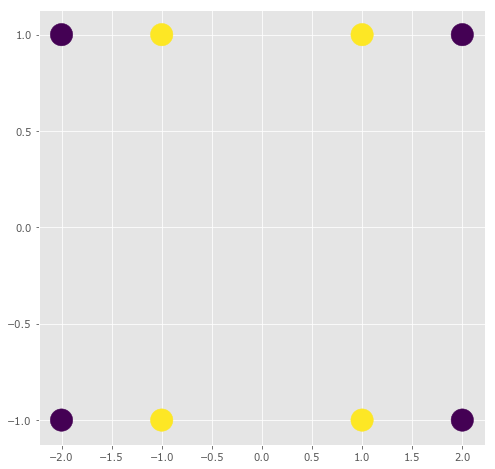

In [5]:
X = np.array([[-2, -1], [-2, 1], [2, -1], [2, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]])
y = np.array([-1,-1,-1,-1,1,1,1,1])

plt.scatter(X[:, 0], X[:, 1], c=y, s=500)

**Вопрос:** Cколько базовых классификаторов достаточно, чтобы правильно классифицировать эти данные?

Запомнили ответ, а теперь посмотрим

In [7]:
ada = AdaBoostClassifier(n_estimators=3, algorithm='SAMME', 
                         base_estimator=DecisionTreeClassifier(max_depth=1))
ada.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=3, random_state=None)

In [8]:
def plot_decision(model, rows=1, columns=3):
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(15,4))
    ax = ax.ravel()

    xx1, xx2 = np.meshgrid(np.arange(X[:,0].min()-1, X[:,0].max()+1, 0.1),
                           np.arange(X[:,1].min()-1, X[:,1].max()+1, 0.1))

    yy = model.staged_predict(np.c_[xx1.ravel(), xx2.ravel()])

    for i, y_hat in enumerate(yy):
        y_hat = y_hat.reshape(xx1.shape)

        ax[i].set_title('iteration %d' % (i+1))
        ax[i].contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
        ax[i].scatter(X[:, 0], X[:, 1], c=y, s=300)

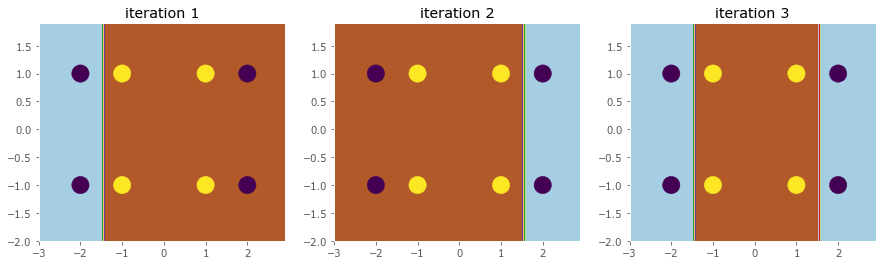

In [9]:
plot_decision(ada)

In [10]:
ada.estimator_weights_

array([ 1.09861229,  1.60943791,  1.38629436])

Ответ: 3! (для дискретного алгоритма) Почему?!<br\> Для вещественного и правда достаточно двух

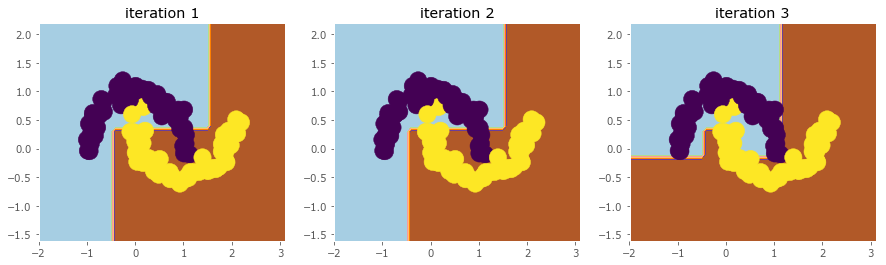

In [15]:
ada_real = AdaBoostClassifier(n_estimators=3, algorithm='SAMME.R', 
                         base_estimator=DecisionTreeClassifier(max_depth=2))
ada_real.fit(X, y)
plot_decision(ada_real)

## Еще игрушки

In [19]:
from sklearn.datasets import make_moons
def ada_demo(n_est=1):

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,), n_estimators=n_est, learning_rate=0.1)
    ada.fit(X, y)
    

    plt.figure(figsize=(7,5))

    xx1, xx2 = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                           np.arange(-1, 1.5, 0.1))

    y_hat = ada.predict(np.c_[xx1.ravel(), xx2.ravel()])
    
    y_hat = y_hat.reshape(xx1.shape)

    plt.title('iteration = %d' % n_est )
    plt.contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    
    plt.show()

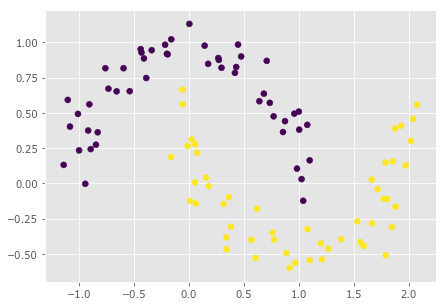

In [20]:
X, y = make_moons(noise=0.1)
plt.figure(figsize=(7,5))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [21]:
interact(ada_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

<function __main__.ada_demo>

# Градиентный бустинг

## Повторяем теорию

Основная идея градиентного бустинга заключается в том, что каждая следующая базовая модель настраивается на "остатки" предыдущих базовых моделей.
По своей структуре метод похож на алгоритм градиентного спуска - отсюда и такое название.

По своей структуре метод похож на алгоритм градиентного спуска - отсюда и такое название.

Пусть дана дифференцируемая функция потерь $L(T_k(x), y)$ (для любой задачи - регрессии или классификации) <br\>
Функционал качества - $Q(T, y) = \sum_iL(T_k(x_i), y_i) = \sum_iL(T_{k-1}(x_i) + \alpha t_{k}(x_i), y_i)$

На секунду представим, что $t_{k}(x)$ - это просто вектор значений. Тогда задачу оптимизации $Q(T, y)$ можно решать простым градиентным методом:

* $T_0$ - начальное приближение
* $T_k = T_{k-1} - \alpha g$ - делаем градиентный шаг
* где $g_i = \frac{\partial L(T_{k-1}(x_i), y_i)}{\partial t_{k-1}(x_i)}$, $i = 1, \dots, N$ - градиент функции потерь

Тогда $t_{k}(x) =  \arg\min\limits_{t} \sum\limits_i(t_{k}(x_i) - g_i)^2$, $\alpha$ определяется в одномерное задаче оптимизации $ \sum_iL(T_{k-1}(x_i) + \alpha t_{k}(x_i), y_i) \rightarrow \min\limits_\alpha$

Наибольший успех, а потому и популярность, получил градиентный бустинг на деревьях решений. Именно с этой его реализацией мы сейчас поработаем

## Игрушечная практика

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

def grad_demo(n_est=1):

    X = np.random.uniform(1, 100, 500)

    y = np.log(X) + np.random.normal(0, .3, 500)
    plt.scatter(X, y)
    

    gbr = GradientBoostingRegressor(n_estimators=n_est, learning_rate=0.15)
    gbr_full = GradientBoostingRegressor(n_estimators=200, learning_rate=0.15)
    gbr.fit(X.reshape(-1,1), y)
    gbr_full.fit(X.reshape(-1,1), y)
    
    x_range = np.linspace(X.min(), X.max(), 100).reshape((-1,1))

    for y_hat in gbr.staged_predict(x_range):
        plt.plot(x_range, y_hat, alpha=0.4, c='g')

    y_hat = gbr_full.predict(x_range)
    
    plt.title('Estimators %d' % n_est)
    plt.plot(x_range, y_hat, c='r')
    
    plt.show()

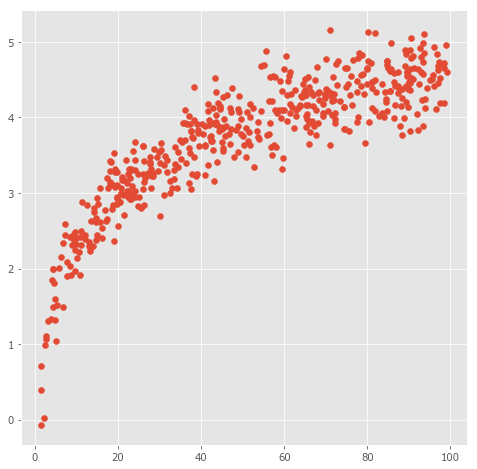

In [26]:
X = np.random.uniform(1, 100, 500)

y = np.log(X) + np.random.normal(0, .3, 500)
plt.scatter(X, y)

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
X = X.reshape(-1, 1)

In [32]:
# Обучите модель и изобразите предсказания на каждом шаге
# Посмотрите, как влияет скорость обучения learning_rate на предсказания

model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, 
                                  n_estimators=200, max_depth=1)
model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [41]:
def grad_demo(n_est=1, lr=0.15):

    X = np.random.uniform(1, 100, 500)

    y = np.log(X) + np.random.normal(0, .3, 500)
    plt.scatter(X, y)
    

    gbr = GradientBoostingRegressor(n_estimators=n_est, 
                                    learning_rate=lr)
    gbr_full = GradientBoostingRegressor(n_estimators=200, 
                                         learning_rate=lr)
    gbr.fit(X.reshape(-1,1), y)
    gbr_full.fit(X.reshape(-1,1), y)
    
    x_range = np.linspace(X.min(), X.max(), 100).reshape((-1,1))

    for y_hat in gbr.staged_predict(x_range):
        plt.plot(x_range, y_hat, alpha=0.4, c='g')

    y_hat = gbr_full.predict(x_range)
    
    plt.title('Estimators %d' % n_est)
    plt.plot(x_range, y_hat, c='b')
    
    plt.show()

In [45]:
interact(grad_demo, 
         n_est=IntSlider(min=1, max=200, step=1), 
         lr=FloatSlider(min=0.01, max=0.5, step=0.05))

<function __main__.grad_demo>

# Настоящая практика

Один из самых важных параметров алгоритма бустинга является количество базовых моделей.<br\>
Слишком большое количество моделей может привести к переобучению, а слишком малое - к недообучению.<br\>
Как бы вы определяли оптимальное количество базовых моделей?

Рассмотрите следующий [набор данных](https://www.dropbox.com/s/zmz41plcrmss26f/california.dat?dl=0). По этой таблице предлагается построить модель, предсказывающую стоимоть дома в калифорнии по остальным прихнакам.

* Загрузите данные и разбейте их на обучающую и контрольную выбору
* Определите оптимальное количество базовых моделей в градиентном бустинге
* Посмотрите, как ваш ответ меняется при изменении скорости обучения
* Посмотрите, как ваш ответ меняется при обучении на случайных подвыборках
* В качестве ошибки используйте MAE

In [48]:
!head california.dat

In [49]:
df = pd.read_csv('california.dat', sep=',')

In [51]:
y, X = df.iloc[:,-1].values, df.iloc[:, :-1].values

In [52]:
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test =\
train_test_split(X, y, 
                 test_size=0.3,
                 random_state=23)

In [82]:
model = GradientBoostingRegressor(max_depth=3, subsample=0.8,
                                  learning_rate=0.3,
                                  n_estimators=200)

In [83]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [84]:
from sklearn.metrics import mean_absolute_error

In [85]:
scores = np.zeros(200)
for i, y_hat_stage in enumerate(model.staged_predict(X_train)):
    scores[i] = mean_absolute_error(y_train, y_hat_stage)
    
scores_test = np.zeros(200)
for i, y_hat_stage in enumerate(model.staged_predict(X_test)):
    scores_test[i] = mean_absolute_error(y_test, y_hat_stage)

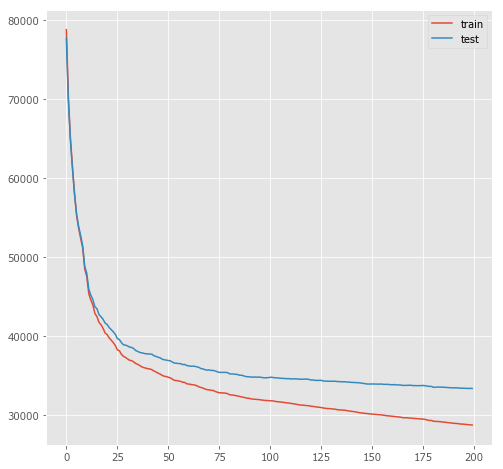

In [86]:
plt.plot(scores, label='train')
plt.plot(scores_test, label='test')
plt.legend()